## Libraries

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

## Data

In [ ]:
df1 = pd.read_csv("/content/job_skills.csv")
len(df1)
print(df1.head())
print(df1.dtypes)


                                            job_link  \
0  https://www.linkedin.com/jobs/view/housekeeper...   
1  https://www.linkedin.com/jobs/view/assistant-g...   
2  https://www.linkedin.com/jobs/view/school-base...   
3  https://www.linkedin.com/jobs/view/electrical-...   
4  https://www.linkedin.com/jobs/view/electrical-...   

                                          job_skills  
0  Building Custodial Services, Cleaning, Janitor...  
1  Customer service, Restaurant management, Food ...  
2  Applied Behavior Analysis (ABA), Data analysis...  
3  Electrical Engineering, Project Controls, Sche...  
4  Electrical Assembly, Point to point wiring, St...  
job_link      object
job_skills    object
dtype: object


In [ ]:
df2 = pd.read_csv("/content/linkedin_job_postings.csv")
len(df2)
print(df2.head())
print(df2.dtypes)

                                            job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/group-unit-...   

             last_processed_time got_summary got_ner is_being_worked  \
0   2024-01-21 07:12:29.00256+00           t       t               f   
1   2024-01-21 07:39:58.88137+00           t       t               f   
2  2024-01-21 07:40:00.251126+00           t       t               f   
3  2024-01-21 07:40:00.308133+00           t       t               f   
4  2024-01-19 09:45:09.215838+00           f       f               f   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURANT SUPERVISOR - THE FORKLIFT   
3     

**checking for overlapping entries**

In [ ]:
c=0
df2_links = set(df2["job_link"])
for link in df1["job_link"]:
  if link not in df2_links:
    c +=1

print(c)

0


In [ ]:
c=0
df1_links = set(df1["job_link"])
for link in df2["job_link"]:
  if link not in df1_links:
    c +=1

print(c)

52073


**removing non-overlapping entries from df2**

In [ ]:
keep_links = set(df1["job_link"])
df2 = df2[df2["job_link"].isin(keep_links)].reset_index(drop=True)


## Data Prep
Working on `job_skills.csv` & `linkedin_job_postings` to create a dataset giving skills for a job title through the common linkage of `job_link` in both the datasets



Removing jobs from df2 that are not entry-level

In [ ]:
df2_na = df2[df2["job_level"] == "Associate"].reset_index(drop=True)
import re

# patterns that indicate non-entry roles
non_entry_terms = [
    "manager", "principal", "supervisor", "specialist", "senior", "lead",
    "director", "vp", "head", r"sr\.?",   # matches "Sr" or "Sr."
]

# build a case-insensitive regex with word boundaries
non_entry_pattern = r"(?i)\b(" + "|".join(non_entry_terms) + r")\b"

# keep only rows whose job_title does NOT contain any of these terms
df2_assoc = df2_na[~df2_na["job_title"].str.contains(non_entry_pattern, na=False)].reset_index(drop=True)

df2_assoc.head(), len(df2_assoc)


/tmp/ipython-input-1678747153.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df2_assoc = df2_na[~df2_na["job_title"].str.contains(non_entry_pattern, na=False)].reset_index(drop=True)


(                                            job_link  \
 0  https://www.linkedin.com/jobs/view/special-age...   
 1  https://www.linkedin.com/jobs/view/control-sys...   
 2  https://mx.linkedin.com/jobs/view/sewer-at-str...   
 3  https://www.linkedin.com/jobs/view/kitchen-pre...   
 4  https://www.linkedin.com/jobs/view/development...   
 
              last_processed_time got_summary got_ner is_being_worked  \
 0  2024-01-21 08:08:21.308995+00           t       t               f   
 1  2024-01-21 08:08:24.021822+00           t       t               f   
 2  2024-01-21 02:01:09.882561+00           t       t               f   
 3  2024-01-21 06:01:14.503312+00           t       t               f   
 4  2024-01-19 14:39:08.158402+00           t       t               f   
 
                               job_title  \
 0   Special Agent: Law/Legal Background   
 1  Control Systems Integration Engineer   
 2                                 Sewer   
 3                          Kitchen Prep

creating a new dataset that has Associate & entry job level for both dataset!

In [ ]:
# keep only the columns we need from df2
df2_small = df2_assoc[["job_link", "job_title"]]

# merge on job_link, then select final columns
df3 = (
    df1.merge(df2_small, on="job_link", how="inner")
       [["job_title", "job_skills"]]
)

#reset index
df3 = df3.reset_index(drop=True)
df3

,job_title,job_skills
0,Performance Analyst ( Material) – Analyste per...,"SAP, DRMIS, Data warehousing, Data analysis, D..."
1,"Analyst, Capital Markets","Debt and equity offering memorandums, Financia..."
2,Laboratory Technician,"Laboratory Technician, Pharmaceutical Testing,..."
3,Insurance Analyst,"Excel, Risk Management, Property Management, I..."
4,Part Time Sales Associate- CALVIN KLEIN,"Customer service, Suggestive selling, UPT, Con..."
...,...,...
110751,Newborn Hearing Screen Technician,"Newborn Hearing Screen Technician, Audiometry,..."
110752,Maintenance Operator,"Maintenance, Installation, Repair, Troubleshoo..."
110753,Industrial Services Laborer,"Power Washing, Hydro blasting, Digging, Sweepi..."
110754,Contract Compliance Officer – Waste Management,IOSH Managing Safely or equivalent Health & Sa...


## Domain classification

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np


In [ ]:
df3 = df3.dropna(subset=["job_title", "job_skills"]).reset_index(drop=True)

In [ ]:
# # 2. Define anchors (if not already defined)
# tech_title_anchors = [
#     "software", "developer", "engineer", "programmer",
#     "devops", "sre", "data scientist", "data engineer",
#     "ml engineer", "machine learning", "full stack",
#     "backend", "front end", "frontend", "cloud",
#     "android", "ios", "data analyst"
# ]

In [ ]:
tech_title_anchors = [
    "software engineer",
    "software developer",
    "backend engineer",
    "frontend engineer",
    "full-stack engineer",
    "systems engineer",
    "platform engineer",
    "site reliability engineer",
    "devops engineer",
    "cloud engineer",
    "infrastructure engineer",
    "application developer",
    "embedded software engineer",
    "mobile engineer",
    "data scientist",
    "data analyst",
    "machine learning engineer",
    "ai engineer",
    "applied scientist",
    "research scientist",
    "data engineer",
    "business intelligence analyst",
    "ml research engineer",
    "deep learning engineer",
    "nlp engineer",
    "computer vision engineer",
    "mlops engineer",
    "cybersecurity engineer",
    "security analyst",
    "security engineer",
    "information security engineer",
    "network engineer",
    "it support engineer",
    "systems administrator",
    "product manager",
    "technical program manager",
    "business analyst",
    "quantitative analyst",
    "data product manager",
    "operations analyst",
    "robotics engineer",
    "ar/vr engineer",
    "autonomous systems engineer",
    "simulation engineer",
    "blockchain engineer",
    "game developer",
    "cloud architect",
    "big data engineer"
]


In [ ]:
# 2. Pre-lowercase title once
df3["job_title_lower"] = df3["job_title"].str.lower()

# 3. Filter ONLY on title (ignore skills)
def is_tech_row(row):
    title = row["job_title_lower"]
    return any(w in title for w in tech_title_anchors)

df3["is_tech"] = df3.apply(is_tech_row, axis=1)
df_tech = df3[df3["is_tech"]].reset_index(drop=True)

print("Total rows:", len(df3))
print("Tech rows (title-based):", len(df_tech))
df_tech[["job_title", "job_skills"]].head()


Total rows: 110605
Tech rows (title-based): 2182


,job_title,job_skills
0,RF Systems Engineer,"RF Systems Engineering, COFDM Modulation Schem..."
1,Security Engineer Associate,"Security Engineering, Physical Security, Camer..."
2,Cyber Security Analyst,"Security and Risk Management, Asset Security, ..."
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...","SQL Server, Power BI, Business Requirements Ga..."
4,Systems Administrator,"Windows computing, Server 2012, Software troub..."


## Binarization of Tech

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from itertools import chain


df_tech #21928 x 5

,job_title,job_skills,job_title_lower,is_tech
0,RF Systems Engineer,"RF Systems Engineering, COFDM Modulation Schem...",rf systems engineer,True
1,Security Engineer Associate,"Security Engineering, Physical Security, Camer...",security engineer associate,True
2,Cyber Security Analyst,"Security and Risk Management, Asset Security, ...",cyber security analyst,True
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...","SQL Server, Power BI, Business Requirements Ga...","business analyst 4 - lansing, mi - 12+ months ...",True
4,Systems Administrator,"Windows computing, Server 2012, Software troub...",systems administrator,True
...,...,...,...,...
2177,Iris Systems Integration Business Analyst (Rem...,"Business Analysis, Project Management, System ...",iris systems integration business analyst (rem...,True
2178,Sales Data Analyst,"Data Analysis, Sales Analysis, ERP Systems, Sa...",sales data analyst,True
2179,Optical Network Engineer,"SDH, PTN, WDM, OTN, NCE, Huawei OSN Serial dev...",optical network engineer,True
2180,Information Security Analyst,"Information Security Analysis, ISO27001 Recert...",information security analyst,True


In [ ]:
# import nltk
# nltk.download('wordnet')

In [ ]:
import json

with open("skill_mapping.json", "r") as f:
    BASIC_SKILLS = json.load(f)

print("Loaded keys:", len(BASIC_SKILLS))
print(BASIC_SKILLS)

with open("new_mapping.json", "r") as f:
    ADDITIONAL_SKILLS = json.load(f)

print("Loaded keys:", len(ADDITIONAL_SKILLS))
print(ADDITIONAL_SKILLS)

with open("new_mappings2.json", "r") as f:
    ADDITIONAL_SKILLS2 = json.load(f)

print("Loaded keys:", len(ADDITIONAL_SKILLS2))
print(ADDITIONAL_SKILLS2)

with open("new_mappings3.json", "r") as f:
    ADDITIONAL_SKILLS3 = json.load(f)

print("Loaded keys:", len(ADDITIONAL_SKILLS3))
print(ADDITIONAL_SKILLS3)

with open("new_mapping4_fixed.json", "r") as f:
    ADDITIONAL_SKILLS4 = json.load(f)

print("Loaded keys:", len(ADDITIONAL_SKILLS4))
print(ADDITIONAL_SKILLS4)

# with open("final_mapping.json", "r") as f:
#     FINAL_SKILLS = json.load(f)

# with open("final_processed.json", "r") as f:
#     FINAL_SKILLS = json.load(f)

# print("Loaded keys:", len(FINAL_SKILLS))
# print(FINAL_SKILLS)

with open("non_relevant_mapping.json", "r") as f:
    NON_RELEVANT_SKILLS_MAPPING = json.load(f)

print("Loaded keys:", len(NON_RELEVANT_SKILLS_MAPPING))
print(NON_RELEVANT_SKILLS_MAPPING)


Loaded keys: 500
{'.net core': '.net', '.net framework': '.net', '401(k)': '401k', '401k plan': '401k', '401k retirement plan': '401k', 'ability to meet deadlines': 'deadline management', 'ability to work in a fastpaced environment': 'work under pressure', 'ability to work independently': 'independent work', 'ability to work independently and as part of a team': 'independent work', 'ability to work under pressure': 'work under pressure', 'access': 'access control', 'advanced ai/machine learning': 'ai', 'advanced aimachine learning': 'machine learning', 'advanced analytics': 'analytics', 'advanced data analytics': 'analytics', 'agile development': 'agile', 'agile environment': 'agile', 'agile methodologies': 'agile', 'agile methodology': 'agile', 'agile/scrum': 'agile', 'agilescrum': 'agile', 'ai/machine learning': 'ai', 'aimachine learning': 'machine learning', 'amazon web services': 'aws', 'amazon web services (aws)': 'aws', 'amazon web services aws': 'aws', 'analytical': 'analytical 

In [ ]:
import re

def canonicalize_skill(skill: str, mappings) -> str:
    skill_clean = skill.strip().lower()
    # --------------------------------------------------
    # 3. CUSTOM CANONICAL RULES FOR COMMON CS SKILLS
    # --------------------------------------------------

    if skill_clean in mappings:
        return mappings[skill_clean]

    return skill_clean


# --------------------------------------------------
# 4. APPLY TO DATASET (df_tech["job_skills"])
# --------------------------------------------------
def split_normalize_and_canonicalize(text):
    if not isinstance(text, str):
        print("Skills are not string")
        return []

    tokens = [t.strip() for t in text.split(",")]
    # print(tokens)
    cleaned = [canonicalize_skill(t,BASIC_SKILLS) for t in tokens]

    cleaned = [canonicalize_skill(t,ADDITIONAL_SKILLS) for t in cleaned]

    cleaned = [canonicalize_skill(t,ADDITIONAL_SKILLS2) for t in cleaned]

    cleaned = [canonicalize_skill(t,ADDITIONAL_SKILLS3) for t in cleaned]

    cleaned = [canonicalize_skill(t,ADDITIONAL_SKILLS4) for t in cleaned]

    # cleaned = [canonicalize_skill(t,FINAL_SKILLS) for t in cleaned]

    cleaned = [canonicalize_skill(t,NON_RELEVANT_SKILLS_MAPPING) for t in cleaned]

    cleaned = sorted(set([c for c in cleaned if c]))
    return cleaned



# Create your skills_list variable
df_tech["skills_list"] = df_tech["job_skills"].apply(split_normalize_and_canonicalize)

In [ ]:
skills_list=df_tech["skills_list"]
skills_list

,skills_list
0,"[.net, asset management, broadcasting, cofdm m..."
1,"[attention to detail, camera management, colla..."
2,"[.net, business unit, ccnpsecurity, communicat..."
3,"[.net, auditing, azure devops, client relation..."
4,"[analysis, azure ad, certification, customer s..."
...,...
2177,"[analysis, business unit, communication, healt..."
2178,"[accounting, analysis, business unit, communic..."
2179,"[compliance, design, network engineering, opti..."
2180,"[communication, compliance, data privacy regul..."


In [ ]:
mlb = MultiLabelBinarizer(sparse_output=True)  # keeps all skills, one column each
X_sparse = mlb.fit_transform(skills_list)

print("Number of unique skills (columns):", len(mlb.classes_))
print("Matrix shape:", X_sparse.shape)  # (n_jobs, n_unique_skills)


Number of unique skills (columns): 5706
Matrix shape: (2182, 5706)


In [ ]:
skills_df = pd.DataFrame.sparse.from_spmatrix(
    X_sparse,
    index=df_tech.index,
    columns=mlb.classes_
)

# Final dataset: job_title + all skill columns
df_tech_bin = pd.concat(
    [df_tech[["job_title"]].reset_index(drop=True),
     skills_df.reset_index(drop=True)],
    axis=1
)

df_tech_bin.head()


,job_title,.net,.net development,.net maui,2 years’ experience as an operations analyst,23 years’ experience,3d modeling,5 10+ years’ experience,5+ years’ experience as business systems engineer,ab initio,...,writing,wsus,x86 architecture,xaml,xml,xp,xray imaging,yaml,zabbix,zero trust
0,RF Systems Engineer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Security Engineer Associate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cyber Security Analyst,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Systems Administrator,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


N most common skills

In [ ]:
# 1. Separate out skill columns (everything except job_title)
skill_cols = df_tech_bin.columns.drop("job_title")

# 2. Compute counts (number of 1s) per skill
skill_counts = df_tech_bin[skill_cols].sum(axis=0)



# 3. Keep only skills with count > 5
# cols_to_keep = skill_counts[(skill_counts > 1) & (skill_counts <= 5)].index
cols_to_keep = skill_counts[skill_counts >5].index
# cols_to_keep = skill_counts.index #not removing any skill


# 4. Rebuild the dataframe: job_title + filtered skills
df_tech_bin_filtered = pd.concat(
    [df_tech_bin[["job_title"]], df_tech_bin[cols_to_keep]],
    axis=1
)

print("Original skill columns:", len(skill_cols))
print("Kept skill columns:", len(cols_to_keep))
df_tech_bin_filtered.head()


Original skill columns: 5706
Kept skill columns: 1086


,job_title,.net,3d modeling,acceptance criteria,access control,account management,accountability,accounting,accuracy,active directory,...,wireless networking,word,work ethic,workday,workflow,workflow management,workload management,writing,xml,zero trust
0,RF Systems Engineer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Security Engineer Associate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cyber Security Analyst,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Systems Administrator,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# list(df_tech_bin_filtered.columns)[:]

In [ ]:
df_tech_bin_filtered.columns


Index(['job_title', '.net', '3d modeling', 'acceptance criteria',
       'access control', 'account management', 'accountability', 'accounting',
       'accuracy', 'active directory',
       ...
       'wireless networking', 'word', 'work ethic', 'workday', 'workflow',
       'workflow management', 'workload management', 'writing', 'xml',
       'zero trust'],
      dtype='object', length=1087)

In [ ]:
skills_df = df_tech_bin_filtered.drop(columns=["job_title", "irrelevant_skill","irrelevant_skills"])
# skills_df["python"].head()

In [ ]:
skills_df.head() #only skills

,.net,3d modeling,acceptance criteria,access control,account management,accountability,accounting,accuracy,active directory,active listening,...,wireless networking,word,work ethic,workday,workflow,workflow management,workload management,writing,xml,zero trust
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
columns_sorted = sorted(skills_df.columns)

# Convert to DataFrame
columns_df = pd.DataFrame(columns_sorted, columns=["column_name"])

# Save to CSV
columns_df.to_csv("sorted_skills.csv", index=False)

In [ ]:
skills_df.columns

Index(['.net', '3d modeling', 'acceptance criteria', 'access control',
       'account management', 'accountability', 'accounting', 'accuracy',
       'active directory', 'active listening',
       ...
       'wireless networking', 'word', 'work ethic', 'workday', 'workflow',
       'workflow management', 'workload management', 'writing', 'xml',
       'zero trust'],
      dtype='object', length=1084)

In [ ]:
len(skills_df) #total job roles

2182

In [ ]:
skills_job_df=df_tech_bin_filtered
skills_job_df

,job_title,.net,3d modeling,acceptance criteria,access control,account management,accountability,accounting,accuracy,active directory,...,wireless networking,word,work ethic,workday,workflow,workflow management,workload management,writing,xml,zero trust
0,RF Systems Engineer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Security Engineer Associate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cyber Security Analyst,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Systems Administrator,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,Iris Systems Integration Business Analyst (Rem...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2178,Sales Data Analyst,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2179,Optical Network Engineer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2180,Information Security Analyst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Hiearchial clustering - not performing well

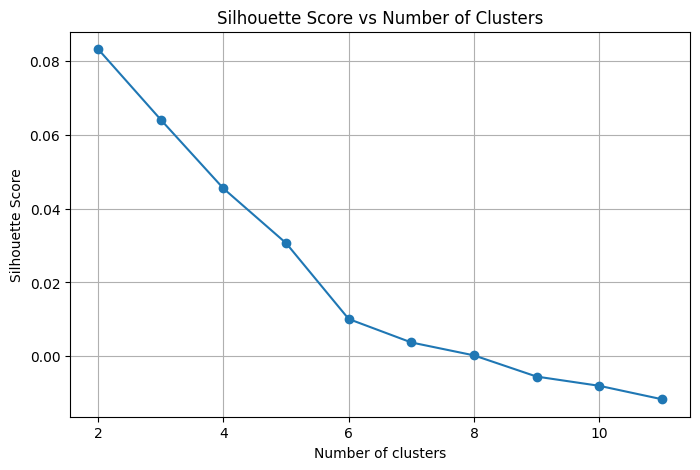

Best number of clusters based on silhouette score: 2

===== Cluster 0 =====
Top Skills:
word processing software                     0
.net                                         0
administration and compliance                0
administration and data management           0
administration and finance                   0
administration and information technology    0
administration and logistics                 0
administration and operations                0
administration and soft skills               0
administration and support                   0
dtype: Sparse[int64, 0]
Top Job Titles:
['RF Systems Engineer', 'Security Engineer Associate', 'Cyber Security Analyst', 'Business Analyst 4 - Lansing, MI - 12+ Months Contract', 'Systems Administrator', 'Research Scientist', 'Research Scientist', 'Research Scientist (Career track)', 'Data Scientist', 'Physicist Research Scientist']

===== Cluster 1 =====
Top Skills:
engineering                                     1
operations and finance

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# ----------------------------
# Step 0: Prepare data
# ----------------------------
X = skills_df  # one-hot matrix without titles
X_norm = normalize(X, norm='l2')  # normalize for cosine distance
job_titles = skills_job_df['job_title']
# print(X_norm)

# ----------------------------
# Step 1: Dendrogram (optional)
# ----------------------------
# plt.figure(figsize=(12, 6))
# # Convert sparse matrix to dense array before passing to linkage
# linked = sch.linkage(X_norm.toarray(), method='average', metric='cosine')
# sch.dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
# plt.title('Hierarchical Clustering Dendrogram (Cosine Distance)')
# plt.xlabel('Jobs')
# plt.ylabel('Distance')
# plt.show()

# ----------------------------
# Step 2: Silhouette Scores to choose best k
# ----------------------------
range_n_clusters = range(2, 12)
sil_scores = []

for n_clusters in range_n_clusters:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
    # Ensure X_norm is dense for fit_predict if it's not already handled internally
    labels = clustering.fit_predict(X_norm.toarray()) # Convert to dense array
    score = silhouette_score(X_norm.toarray(), labels, metric='cosine') # Convert to dense array
    sil_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

best_k = range_n_clusters[np.argmax(sil_scores)]
print(f"Best number of clusters based on silhouette score: {best_k}")

# ----------------------------
# Step 3: Final Clustering
# ----------------------------
clustering = AgglomerativeClustering(n_clusters=best_k, metric='cosine', linkage='average')
labels = clustering.fit_predict(X_norm.toarray()) # Convert to dense array

# ----------------------------
# Step 4: Add cluster labels to skills_job_df
# ----------------------------
skills_job_df['cluster_hier'] = labels

# ----------------------------
# Step 5: Extract top skills and top jobs per cluster
# ----------------------------
cluster_summary = {}

for c in range(best_k):
    cluster_indices = skills_job_df[skills_job_df['cluster_hier'] == c].index
    cluster_matrix = skills_df.iloc[cluster_indices]

    # Top skills by mean frequency
    skill_means = cluster_matrix.mean(axis=0).sort_values(ascending=False)

    # Top jobs (first 10)
    top_jobs = skills_job_df.iloc[cluster_indices]['job_title'].tolist()[:10]

    cluster_summary[c] = {
        'Top Skills': skill_means.head(10),
        'Top Job Titles': top_jobs
    }

# ----------------------------
# Step 6: Display clusters
# ----------------------------
for c, summary in cluster_summary.items():
    print(f"\n===== Cluster {c} =====")
    print("Top Skills:")
    print(summary['Top Skills'])
    print("Top Job Titles:")
    print(summary['Top Job Titles'])

Kmeans

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



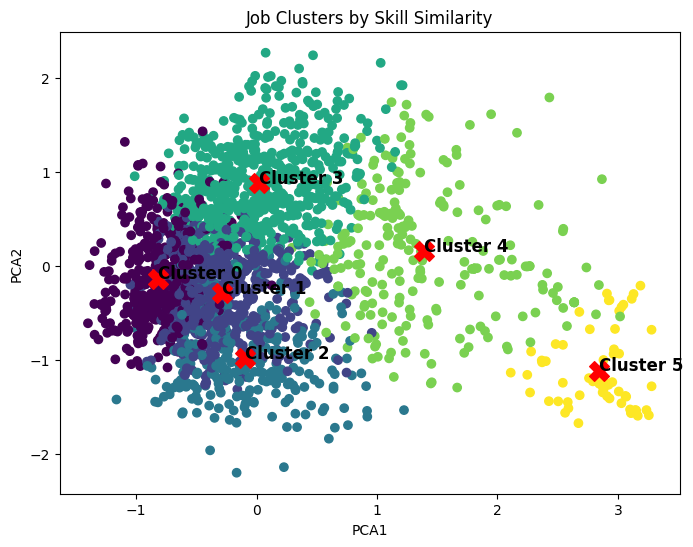

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
result_kmeans = kmeans.fit_predict(skills_df)

pca = PCA(n_components=2)
reduced = pca.fit_transform(skills_df)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=result_kmeans, cmap='viridis')

# Plot centroids
centroids_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1],
            s=200, c='red', marker='X')

# Add cluster labels
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f"Cluster {i}", fontsize=12, fontweight='bold')

plt.title('Job Clusters by Skill Similarity')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


In [ ]:
skills_job_df['cluster_kmeans']=result_kmeans

In [ ]:
import numpy as np
import pandas as pd

skill_cols = skills_df.columns  # list of all skill names

cluster_skill_summary_kmeans = {}

for c in range(k):

    # rows belonging to this cluster
    cluster_indices = skills_job_df[skills_job_df['cluster_kmeans'] == c].index

    if len(cluster_indices) == 0:
        print(f"\n===== Cluster {c} — EMPTY CLUSTER =====")
        cluster_skill_summary_kmeans[c] = None
        continue

    # extract the rows from skills_df
    cluster_matrix = skills_df.iloc[cluster_indices]

    # convert sparse columns to dense float to avoid locked 0/1 behavior
    cluster_matrix_dense = cluster_matrix.sparse.to_dense().astype(float)

    # compute mean frequency of each skill
    skill_means = cluster_matrix_dense.mean(axis=0).sort_values(ascending=False)

    cluster_skill_summary_kmeans[c] = skill_means

    print(f"\n===== Cluster {c} — Top Skills =====")
    print(skill_means.head(10))




===== Cluster 0 — Top Skills =====
security               0.630923
.net                   0.556110
network engineering    0.546135
communication          0.361596
systems engineering    0.326683
troubleshooting        0.271820
linux                  0.246883
problem solving        0.214464
windows                0.209476
cisco                  0.204489
dtype: float64

===== Cluster 1 — Top Skills =====
software development    0.350000
communication           0.266667
programming             0.260000
systems engineering     0.251667
engineering             0.240000
c++                     0.226667
python                  0.213333
problem solving         0.185000
.net                    0.155000
linux                   0.151667
dtype: float64

===== Cluster 2 — Top Skills =====
python             0.661765
aws                0.500000
agile              0.455882
java               0.448529
kubernetes         0.363971
sql                0.334559
javascript         0.334559
cloud computing 

In [ ]:
for c in range(k):
    print(f"\n===== Cluster {c} — Top Job Roles =====")
    print(skills_job_df[skills_job_df['cluster_kmeans'] == c]['job_title'].value_counts().head(5))



===== Cluster 0 — Top Job Roles =====
job_title
Network Engineer                           54
Cyber Security Analyst                     13
Systems Engineer                           13
Systems Administrator                       9
Security Engineer - Threat Intelligence     8
Name: count, dtype: int64

===== Cluster 1 — Top Job Roles =====
job_title
Software Engineer             49
Systems Engineer              19
Embedded Software Engineer    19
Software Developer            13
Business Analyst              13
Name: count, dtype: int64

===== Cluster 2 — Top Job Roles =====
job_title
Software Engineer                    33
DevOps Engineer                      16
Data Engineer                        10
Systems Engineer - Bot Management     7
Machine Learning Engineer             7
Name: count, dtype: int64

===== Cluster 3 — Top Job Roles =====
job_title
Business Analyst              92
Data Analyst                  16
Operations Analyst             9
IT Business Analyst            7

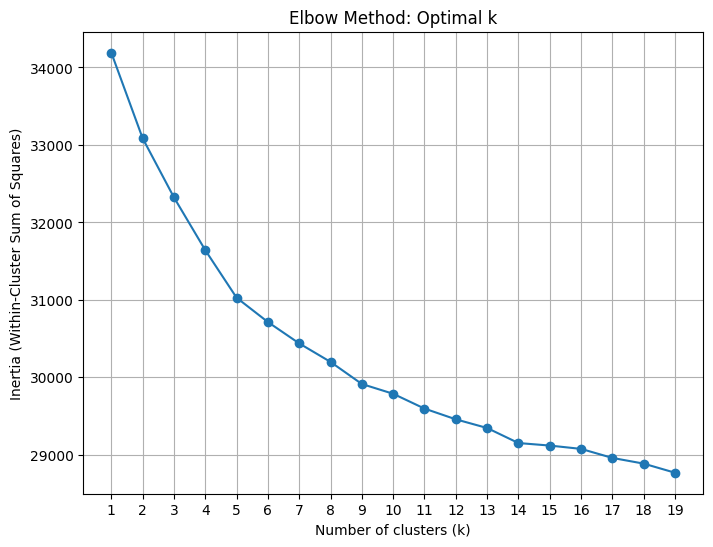

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_values = []
k_values = range(1, 20)   # test k from 1 to 15

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    # from sklearn.cluster import MiniBatchKMeans

    # kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
    kmeans_temp.fit(skills_df)
    inertia_values.append(kmeans_temp.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


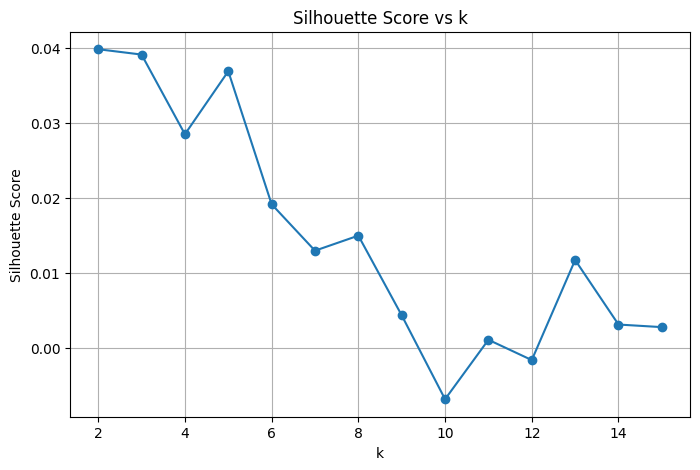

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_values = range(2, 16)

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_temp.fit_predict(skills_df)
    score = silhouette_score(skills_df, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


MiniBatchKmeans

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


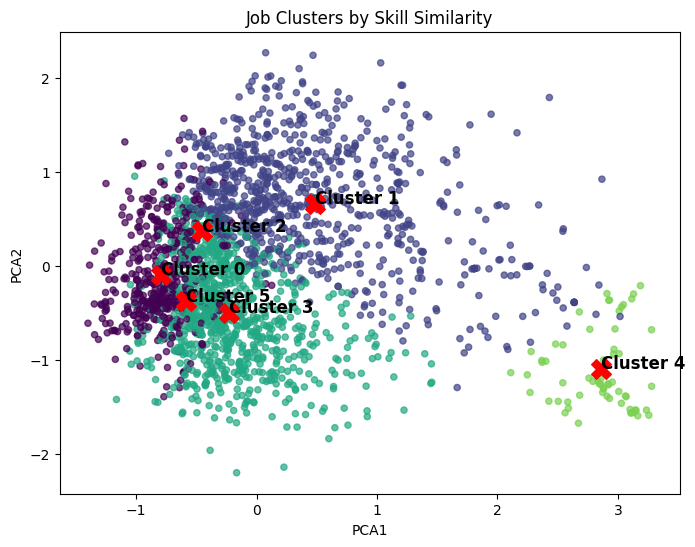

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

k = 6
from sklearn.cluster import MiniBatchKMeans

kmeans_batch = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
result_batch = kmeans_batch.fit_predict(skills_df)

pca = PCA(n_components=2)
reduced = pca.fit_transform(skills_df)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=result_batch, cmap='viridis', s=20, alpha=0.7)

# Plot centroids
centroids_2d = pca.transform(kmeans_batch.cluster_centers_)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1],
            s=200, c='red', marker='X')

# Add cluster labels
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f"Cluster {i}", fontsize=12, fontweight='bold')

plt.title('Job Clusters by Skill Similarity')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [ ]:
skills_job_df['cluster_batch_kmeans']=result_batch

In [ ]:
import numpy as np
import pandas as pd

skill_cols = skills_df.columns  # list of all skill names

cluster_skill_summary_batch_kmeans = {}

for c in range(k):

    # rows belonging to this cluster
    cluster_indices = skills_job_df[skills_job_df['cluster_batch_kmeans'] == c].index

    if len(cluster_indices) == 0:
        print(f"\n===== Cluster {c} — EMPTY CLUSTER =====")
        cluster_skill_summary_batch_kmeans[c] = None
        continue

    # extract the rows from skills_df
    cluster_matrix = skills_df.iloc[cluster_indices]

    # convert sparse columns to dense float to avoid locked 0/1 behavior
    cluster_matrix_dense = cluster_matrix.sparse.to_dense().astype(float)

    # compute mean frequency of each skill
    skill_means = cluster_matrix_dense.mean(axis=0).sort_values(ascending=False)

    cluster_skill_summary_batch_kmeans[c] = skill_means

    print(f"\n===== Cluster {c} — Top Skills =====")
    print(skill_means.head(10))




===== Cluster 0 — Top Skills =====
security               0.648770
network engineering    0.516779
.net                   0.514541
communication          0.395973
systems engineering    0.297539
troubleshooting        0.259508
problem solving        0.217002
linux                  0.212528
windows                0.192394
cisco                  0.187919
dtype: float64

===== Cluster 1 — Top Skills =====
data analysis         0.677541
communication         0.633626
business unit         0.526976
problem solving       0.383940
sql                   0.375157
project management    0.350063
analysis              0.312422
excel                 0.296110
data visualization    0.294856
reporting             0.245922
dtype: float64

===== Cluster 2 — Top Skills =====
attention to detail    1.0
virtual reality        1.0
ar                     1.0
version control        1.0
teamwork               1.0
qt                     1.0
software testing       1.0
simulation             1.0
communication   

In [ ]:
for c in range(k):
    print(f"\n===== Cluster {c} — Top Job Roles =====")
    print(skills_job_df[skills_job_df['cluster_batch_kmeans'] == c]['job_title'].value_counts().head(5))



===== Cluster 0 — Top Job Roles =====
job_title
Network Engineer          56
Systems Engineer          14
Cyber Security Analyst    14
Security Analyst          10
Systems Administrator      9
Name: count, dtype: int64

===== Cluster 1 — Top Job Roles =====
job_title
Business Analyst                                         84
Data Analyst                                             56
Data Analyst (Bangkok Based, relocation provided)        22
Business Analyst (Bangkok Based, relocation provided)    21
Data Scientist                                           11
Name: count, dtype: int64

===== Cluster 2 — Top Job Roles =====
job_title
Simulator Systems Software Engineer - TRU Simulation + Training, Inc.    2
Name: count, dtype: int64

===== Cluster 3 — Top Job Roles =====
job_title
Software Engineer             84
Business Analyst              24
Embedded Software Engineer    19
Data Engineer                 18
DevOps Engineer               18
Name: count, dtype: int64

===== Cluster 

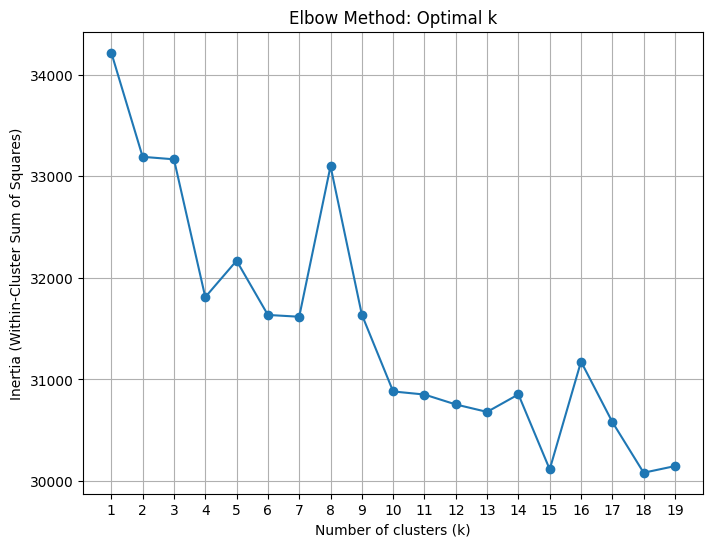

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_values = []
k_values = range(1, 20)   # test k from 1 to 15

for k in k_values:
    # kmeans = KMeans(n_clusters=k, random_state=42)
    from sklearn.cluster import MiniBatchKMeans

    kmeans_temp_batch = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
    kmeans_temp_batch.fit(skills_df)
    inertia_values.append(kmeans_temp_batch.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


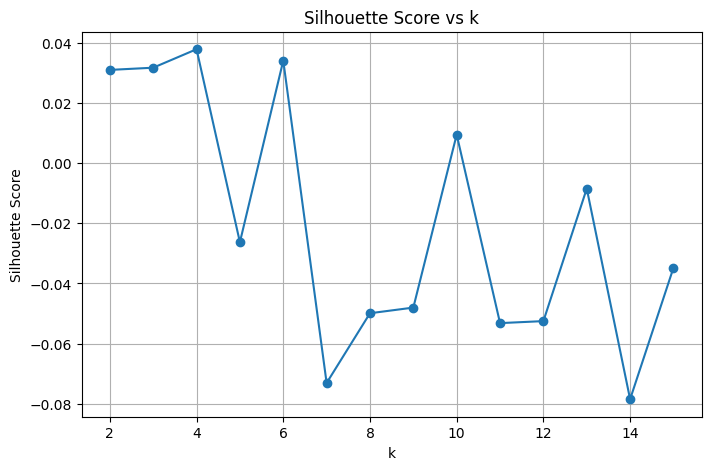

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_values = range(2, 16)

for k in k_values:
    # kmeans = KMeans(n_clusters=k, random_state=42)
    from sklearn.cluster import MiniBatchKMeans

    kmeans_temp_batch = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
    labels = kmeans_temp_batch.fit_predict(skills_df)
    score = silhouette_score(skills_df, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [ ]:
# skills = [ "cybersecurity"]
skills  = [
    "Python", "R", "SQL", "Java", "C/C++", "PostgreSQL", "BigQuery", "JavaScript",
    "Jenkins", "Git", "GCP", "DevOps", "Docker", "Kubernetes", "PySpark",
    "Data Visualization", "Prometheus", "Data Integration", "AWS",
    "PyTorch", "Natural Language Processing (NLP)", "Neural Networks",
    "CNN", "RNN", "LSTM", "GRU", "FeedForward Networks", "Deep Learning",
    "Generative AI", "Recommendation System", "MLOps", "Anomaly Detection",
    "LLMs", "Graph Neural Networks", "Vertex AI", "Prompt Engineering",
    "NumPy", "Matplotlib", "Pandas", "NLTK", "Scikit-Learn", "OpenCV",
    "Grafana", "Snowflake", "Streamlit", "FastAPI", "Keras", "TensorFlow"
]
# skills = [
#     "Java", "C/C++", "Python", "FastAPI", "SQL", "PostgreSQL", "Flask", "Go",
#     "React", "JavaScript", "Typescript", "Node.js", "Kotlin",
#     "SpringBoot", "Docker", "Kubernetes", "JUnit", "Git", "AWS (S3, DynamoDB)",
#     "GCP", "ServiceNow", "Grafana", "Cassandra",
#     "Object Oriented Programming", "System Design", "Design Patterns",
#     "Microservices", "Distributed Systems", "CI/CD", "Concurrency",
#     "Mobile Application Development", "Web Application Development",
#     "Software Development Life Cycle",
#     "Reinforcement Learning", "Large Language Model (LLM)", "RAG",
#     "TensorFlow", "PyTorch", "Keras", "NumPy", "Pandas", "OpenCV",
#     "Natural Language Processing", "Graph Neural Network", "Scikit-Learn",
#     "GenAI", "Prompt Engineering", "Computer Vision"
# ]
# skills = [
#     "Python", "SQL", "NoSQL", "PL/SQL", "R", "VBA Dashboards", "Power BI",
#     "Machine Learning", "Data Analytics", "Predictive Modelling", "Visualization",
#     "Pandas", "NumPy", "TensorFlow", "Scikit-Learn", "Matplotlib", "Seaborn",
#     "Snowflake", "MongoDB", "Neo4j"
# ]
# user_skills = [s.lower() for s in skills]
# First skill set
anshika = "Python, R, SQL, Java, C/C++, PostgreSQL, BigQuery, JavaScript, Jenkins, Git, GCP, DevOps, Docker, Kubernetes, PySpark, Data Visualization, Prometheus, Data Integration, AWS, PyTorch, Natural Language Processing (NLP), Neural Networks, CNN, RNN, LSTM, GRU, FeedForward Networks, Deep Learning, Generative AI, Recommendation System, MLOps, Anomaly Detection, LLMs, Graph Neural Networks, Vertex AI, Prompt Engineering, NumPy, Matplotlib, Pandas, NLTK, Scikit-Learn, OpenCV, Grafana, Snowflake, Streamlit, FastAPI, Keras, TensorFlow"
anshika = "Python, SQL, C/C++, PostgreSQL, BigQuery,  Jenkins, Git, GCP,  PySpark, Data Visualization, Prometheus, Data Integration, PyTorch, Natural Language Processing (NLP), Neural Networks, CNN, RNN, LSTM, GRU, FeedForward Networks, Deep Learning, Generative AI, Anomaly Detection, LLMs,  Vertex AI, Prompt Engineering, NumPy, Matplotlib, Pandas, NLTK, Scikit-Learn, OpenCV, Grafana, Snowflake, Streamlit, FastAPI, Keras, TensorFlow"

# Second skill set
mayank = "Java, C/C++, Python, FastAPI, SQL, PostgreSQL, Flask, Go, React, JavaScript, Typescript, Node.js, Kotlin, SpringBoot, Docker, Kubernetes, JUnit, Git, AWS (S3, DynamoDB), GCP, ServiceNow, Grafana, Cassandra, Object Oriented Programming, System Design, Design Patterns, Microservices, Distributed Systems, CI/CD, Concurrency, Mobile Application Development, Web Application Development, Software Development Life Cycle, Reinforcement Learning, Large Language Model (LLM), RAG, TensorFlow, PyTorch, Keras, NumPy, Pandas, OpenCV, Natural Language Processing, Graph Neural Network, Scikit-Learn, GenAI, Prompt Engineering, Computer Vision"
mayank = "Java, C/C++, Python, FastAPI, SQL, PostgreSQL, React, JavaScript, Node.js, SpringBoot, Docker, Kubernetes, JUnit, Git, AWS (S3, DynamoDB), ServiceNow, Grafana, Object Oriented Programming, System Design, Design Patterns, Microservices, Distributed Systems, CI/CD, Concurrency, Web Application Development, Software Development Life Cycle, Reinforcement Learning, Large Language Model (LLM), RAG, TensorFlow, PyTorch, NumPy, Pandas, Natural Language Processing, Scikit-Learn, GenAI, Prompt Engineering, Computer Vision"

# Third skill set
friend = "Python, SQL, NoSQL, PL/SQL, R, VBA Dashboards, Power BI, Machine Learning, Data Analytics, Predictive Modelling, Visualization, Pandas, NumPy, TensorFlow, Scikit-Learn, Matplotlib, Seaborn, Snowflake, MongoDB, Neo4j"

skills=mayank
user_skills=split_normalize_and_canonicalize(skills)

def encode_user_skills(user_skills, all_skills):
    vec = np.zeros(len(all_skills))
    for skill in user_skills:
        if skill in all_skills:
            print(skill)
            vec[all_skills.index(skill)] = 1
    return vec

all_skills = skills_df.columns.tolist()
user_vector = encode_user_skills(user_skills, all_skills).reshape(1, -1)


c++
ci/cd
computer vision
design patterns
distributed systems
docker
git
grafana
java
javascript
junit
kubernetes
machine learning
microservices
nlp
node.js
numpy
oop
pandas
parallel programming
postgresql
python
pytorch
react
sdlc
servicenow
spring boot
sql
systems engineering
tensorflow
web development


In [ ]:
skill_cols = skills_df.columns.tolist()

user_vector = pd.Series(0, index=skill_cols)
for skill in user_skills:
    if skill in user_vector.index:
        print(skill)
        user_vector[skill] = 1


c++
ci/cd
computer vision
design patterns
distributed systems
docker
git
grafana
java
javascript
junit
kubernetes
machine learning
microservices
nlp
node.js
numpy
oop
pandas
parallel programming
postgresql
python
pytorch
react
sdlc
servicenow
spring boot
sql
systems engineering
tensorflow
web development


In [ ]:
user_vector.sort_values(ascending=False).head(20)

,0
design patterns,1
kubernetes,1
systems engineering,1
junit,1
sql,1
spring boot,1
javascript,1
java,1
parallel programming,1
microservices,1


batch is better

In [ ]:
algo_col_name="cluster_kmeans"
cluster_skill_summary=cluster_skill_summary_kmeans

result is incorrect, need to debug, check cluster 0th indexing and 1,

In [ ]:
skills_job_df[algo_col_name].unique()

array([0, 3, 1, 4, 2, 5], dtype=int32)

In [ ]:
cluster_centroids = {}

for c in range(k):
    idx = skills_job_df[skills_job_df[algo_col_name] == c].index

    if len(idx) == 0:
        continue

    # Convert sparse to dense before mean
    centroid = (
        skills_df.iloc[idx]
        .sparse.to_dense()
        .astype(float)
        .mean(axis=0)
        .values   # ✅ convert to NumPy array
    )

    cluster_centroids[c] = centroid


In [ ]:
user_vec = user_vector.values.astype(float).reshape(1, -1)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = {}

for c, centroid in cluster_centroids.items():
    centroid_vec = centroid.reshape(1, -1)   # ✅ NOW this works
    sim = cosine_similarity(user_vec, centroid_vec)[0][0]
    similarities[c] = sim

best_cluster = max(similarities, key=similarities.get)

print("✅ Correct Closest Cluster by Similarity:", best_cluster)
print("✅ All Similarities:", similarities)


✅ Correct Closest Cluster by Similarity: 2
✅ All Similarities: {0: np.float64(0.0687630017813124), 1: np.float64(0.31767916392601664), 2: np.float64(0.4331868765799243), 3: np.float64(0.06043603650412197), 4: np.float64(0.19473939824761544), 5: np.float64(0.20471558397130374)}


In [ ]:
def recommend_missing_skills_from_cluster(user_vector, cluster_skill_summary, cluster_id, top_n=5):

    skill_means = cluster_skill_summary[cluster_id]

    if skill_means is None:
        print("⚠️ Empty cluster — no recommendations available.")
        return None

    # Mask skills the user already has
    missing_skills = skill_means[user_vector == 0]

    return missing_skills.head(top_n)

recommended_skills = recommend_missing_skills_from_cluster(
    user_vector=user_vector,
    cluster_skill_summary=cluster_skill_summary, #update this
    cluster_id=best_cluster,
    top_n=5
)

print("\n✅ Recommended Missing Skills:")
print(recommended_skills)



✅ Recommended Missing Skills:
aws                0.500000
agile              0.455882
cloud computing    0.312500
linux              0.305147
devops             0.294118
dtype: float64


In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Job vectors (dense)
job_matrix_dense = skills_df.sparse.to_dense().astype(float).values

# Centroids + user
centroid_matrix = np.vstack(list(cluster_centroids.values()))
vectors_for_pca = np.vstack([job_matrix_dense, centroid_matrix, user_vec])  # JOB first, then CENTROID, then USER

# Labels for hover
labels = skills_job_df["job_title"].tolist() + [f"Cluster {c}" for c in cluster_centroids.keys()] + ["USER"]

# Role type for coloring
types = ["JOB"] * job_matrix_dense.shape[0] + ["CENTROID"] * len(cluster_centroids) + ["USER"]


In [ ]:
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors_for_pca)

df_plot = pd.DataFrame({
    "x": vectors_2d[:, 0],
    "y": vectors_2d[:, 1],
    "label": labels,
    "type": types
})


In [ ]:
fig = px.scatter(
    df_plot,
    x="x",
    y="y",
    color="type",
    symbol="type",
    hover_name="label",
    size=[6 if t=="JOB" else 12 if t=="CENTROID" else 15 for t in df_plot["type"]],
    color_discrete_map={"USER":"red","CENTROID":"blue","JOB":"lightgray"}
)

fig.update_layout(
    title="User Skill Vector vs Job Clusters (Interactive PCA)",
    xaxis_title="PCA Component 1",
    yaxis_title="PCA Component 2",
    legend_title="Point Type",
    width=900,
    height=700
)

fig.show()


HELPER FUNCTIONS for calculating the mapping
strings=list(df_tech_bin_filtered.columns)[:]
from collections import Counter

first_words = [s.split()[0] for s in strings]
counts = Counter(first_words)

print(counts)


prefix = "project"
map_value = "project management"

matches = [s for s in strings if s.startswith(prefix)]

print(f"Strings starting with '{prefix}':")
for m in matches:
    print(" -", m)

mapping = {s: map_value for s in matches if s.startswith(prefix)}

mapping
# Mapping dictionary
data_mapping1 = {
  "project": "project management",
  "it": "it"

}

data_mapping=ADDITIONAL_SKILLS3
# Generate mapping for strings that start with any key in data_mapping
mapped_strings = {}

for s in strings:
    for key, value in data_mapping.items():
        if s.lower().startswith(key.lower()):  # case-insensitive match
            mapped_strings[s] = value
            # break  # stop after first match

# Output
# mapped_strings
with open("new_mappings4.json", "w") as f:
    json.dump(mapped_strings, f, indent=4)

print("Dictionary saved as data_mapping.json")
import pandas as pd
import json

# Your dictionary
skill_mappings = NEW_MAPPINGS
file_name = "new_mappings3.json"

# Create DataFrame with all operations
df_final = (pd.DataFrame(list(skill_mappings.items()), columns=['skill', 'mapping'])
            .drop_duplicates()
            .sort_values(by='skill')
            .reset_index(drop=True))

print("Final DataFrame:")
print(df_final)

# Convert to dictionary format {skill: mapping}
skill_mapping_dict = df_final.set_index('skill')['mapping'].to_dict()

# Save to JSON
with open(file_name, 'w') as f:
    json.dump(skill_mapping_dict, f, indent=2)

print(f'\n✓ JSON file saved as {file_name}')

# # Display the JSON content
# with open(file_name, 'r') as f:
#     print("\nJSON Content:")
#     print(f.read())


In [ ]:
strings=list(df_tech_bin_filtered.columns)[:]
from collections import Counter

first_words = [s.split()[0] for s in strings]
counts = Counter(first_words)

print(counts)



Counter({'data': 349, 'project': 94, 'cloud': 81, 'software': 65, 'security': 63, 'process': 60, 'product': 59, 'enterprise': 58, 'customer': 57, 'database': 50, 'computer': 36, 'it': 35, 'business': 34, 'complex': 33, 'network': 32, 'systems': 31, 'engineering': 30, 'finance': 30, 'power': 30, 'financial': 28, 'electrical': 26, 'communication': 25, 'healthcare': 25, 'programming': 25, 'public': 25, 'soft': 24, 'compliance': 23, 'embedded': 23, 'hardware': 22, 'professional': 22, 'program': 22, 'aws': 21, 'information': 21, 'web': 21, 'change': 20, 'continuous': 20, 'documentation': 19, 'erp': 19, 'networking': 19, 'configuration': 18, 'quantitative': 18, 'code': 17, 'crm': 17, 'electronic': 17, 'microsoft': 17, 'proficiency': 17, 'sales': 17, 'certified': 16, 'collaboration': 16, 'cost': 16, 'distributed': 16, 'system': 16, 'company': 15, 'equipment': 15, 'risk': 15, 'cloudbased': 14, 'crossfunctional': 14, 'cyber': 14, 'problem': 14, 'technical': 14, 'container': 13, 'epic': 13, 'gov

In [ ]:
prefix = "project"
map_value = "project management"

matches = [s for s in strings if s.startswith(prefix)]

print(f"Strings starting with '{prefix}':")
for m in matches:
    print(" -", m)

mapping = {s: map_value for s in matches if s.startswith(prefix)}

mapping

Strings starting with 'project':
 - project activities
 - project administration
 - project analysis
 - project and process tasks/flows
 - project artifacts
 - project audits
 - project automation
 - project budget
 - project budget and schedule management
 - project budget definition
 - project charters
 - project closure
 - project controls
 - project costing
 - project discovery
 - project documents
 - project engagement for finance system improvement
 - project engineering
 - project estimating
 - project evaluation
 - project expenditure monitoring
 - project formulation and planning
 - project framework
 - project governance
 - project handoff
 - project handoff and closure
 - project health monitoring
 - project information management
 - project justification
 - project lead
 - project leading
 - project life cycle
 - project life cycle process
 - project lifecycle
 - project management concepts
 - project management fundamentals
 - project management institute project managemen

{'project activities': 'project management',
 'project administration': 'project management',
 'project analysis': 'project management',
 'project and process tasks/flows': 'project management',
 'project artifacts': 'project management',
 'project audits': 'project management',
 'project automation': 'project management',
 'project budget': 'project management',
 'project budget and schedule management': 'project management',
 'project budget definition': 'project management',
 'project charters': 'project management',
 'project closure': 'project management',
 'project controls': 'project management',
 'project costing': 'project management',
 'project discovery': 'project management',
 'project documents': 'project management',
 'project engagement for finance system improvement': 'project management',
 'project engineering': 'project management',
 'project estimating': 'project management',
 'project evaluation': 'project management',
 'project expenditure monitoring': 'project man

In [ ]:
# Mapping dictionary
data_mapping1 = {
  "project": "project management",
  "it": "it"

}

data_mapping=ADDITIONAL_SKILLS3
# Generate mapping for strings that start with any key in data_mapping
mapped_strings = {}

for s in strings:
    for key, value in data_mapping.items():
        if s.lower().startswith(key.lower()):  # case-insensitive match
            mapped_strings[s] = value
            # break  # stop after first match

# Output
# mapped_strings
with open("new_mappings4.json", "w") as f:
    json.dump(mapped_strings, f, indent=4)

print("Dictionary saved as data_mapping.json")

Dictionary saved as data_mapping.json


In [ ]:
import pandas as pd
import json

# Your dictionary
skill_mappings = NEW_MAPPINGS
file_name = "new_mappings3.json"

# Create DataFrame with all operations
df_final = (pd.DataFrame(list(skill_mappings.items()), columns=['skill', 'mapping'])
            .drop_duplicates()
            .sort_values(by='skill')
            .reset_index(drop=True))

print("Final DataFrame:")
print(df_final)

# Convert to dictionary format {skill: mapping}
skill_mapping_dict = df_final.set_index('skill')['mapping'].to_dict()

# Save to JSON
with open(file_name, 'w') as f:
    json.dump(skill_mapping_dict, f, indent=2)

print(f'\n✓ JSON file saved as {file_name}')

# # Display the JSON content
# with open(file_name, 'r') as f:
#     print("\nJSON Content:")
#     print(f.read())

Final DataFrame:
                                                  skill  \
0          2 years' experience as an operations analyst   
1                                  23 years' experience   
2                              5  10+ years' experience   
3     5+ years' experience as business systems engineer   
4                                              abinitio   
...                                                 ...   
4019                                          zerotrust   
4020                                             zigbee   
4021                                          zookeeper   
4022                                               zoom   
4023                                            zscaler   

                           mapping  
0              operations analysis  
1                 irrelevant_skill  
2                 irrelevant_skill  
3     business systems engineering  
4                        ab initio  
...                            ...  
4019           

In [ ]:
with open("new_mapping4.json", "r") as f:
    json1 = json.load(f)

with open("incorrect_ones.json", "r") as f:
    json2 = json.load(f)

In [ ]:
import json

# Your original dictionaries
# json1 = {"a": 1, "b": 2, "c": 3, "d": 4}
# json2 = {"b": 5, "d": 6}

# Remove keys from json1 that exist in json2
filtered_json1 = {key: value for key, value in json1.items() if key not in json2}

# Combine filtered_json1 and json2
json3 = {**filtered_json1, **json2}

print(json3)  # Output: {'a': 1, 'c': 3, 'b': 5, 'd': 6}

# Save to a file
with open('new_mapping4_fixed.json', 'w') as f:
    json.dump(json3, f, indent=4)

print("Saved to new_mapping4_fixed.json")

{'accessibility': 'access control', 'accreditation': 'compliance', 'actuarial science': 'actuarial science', 'agriculture': 'agriculture', 'analytics degree': 'data analysis', 'application development': 'software development', 'ar': 'ar', 'architecture': 'ar', 'artifact repository': 'ar', 'artifactory': 'ar', 'aruba networks': 'ar', 'audio engineering': 'audio engineering', 'audiovisual': 'audiovisual', 'authorization': 'authorization', 'automotive': 'automotive', 'automotive engineering': 'automotive engineering', 'automotive protocols': 'automotive', 'automotive testing': 'automotive testing', 'autosar': 'autosar', 'aviation': 'aviation', 'aviation standards': 'aviation', 'avionics': 'audiovisual', 'aws cdk': 'aws', 'aws cloudformation': 'aws cloudformation', 'aws cloudfront': 'aws', 'aws ec2': 'aws ec2', 'aws ecs': 'aws ecs', 'aws glue': 'aws glue', 'aws govcloud': 'aws govcloud', 'aws lambda': 'aws lambda', 'aws quicksight': 'aws quicksight', 'aws rds': 'aws rds', 'aws redshift': '